Find images to use

In [1]:
pip install -r  requirements.txt -q


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Define the blackbox model

In [5]:
from typing import List
from sklearn import preprocessing

def encode_categorical_values(values: List[str]):
    unique_values = sorted(list(set(values)))
    le = preprocessing.LabelEncoder()
    le.fit(unique_values)
    return le
label_encoder = encode_categorical_values(unique_labels)

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array

blackbox_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

def preprocess_images(img_array):
    img_array = np.array([tf.image.resize(img_to_array(img), (224, 224)) for img in img_array])
    return preprocess_input(img_array)

def black_box_classify(img_array,convert_to_nr=True):
    preprocessed_imgs = preprocess_images(img_array)
    predictions = blackbox_model.predict(preprocessed_imgs)
    prediction_labels = decode_predictions(predictions, top = 1)
    labels_as_str = [row[0][1] for row in prediction_labels]
    if convert_to_nr:
        label_as_nr = label_encoder.transform(labels_as_str)
        return [[l]for l in label_as_nr]
    return [[l]for l in labels_as_str]

Import raw data

In [7]:
import numpy as np
import pickle
import hashlib
import pandas as pd

np.random.seed(42)

base_path = "/Users/karlgustav/Documents/GitHub/study/master-thesis/server/src/research/"
# base_path = "/Users/karl-gustav.kallasmaa/Documents/Projects/master-thesis/server/src/"
all_labels_path = f"{base_path}all_classes.txt"
masks_path = f"{base_path}data/masks.pkl"
img_path = f"{base_path}data/resized_imgs.pkl"
labels_path = f"{base_path}data/classes.pkl"
ade_path = f"{base_path}data/objectInfo150.csv"

ade_classes = pd.read_csv(ade_path)

images = []
masks = []
unique_labels = []
raw_labels = []
with open(masks_path, 'rb') as f:
    masks = pickle.load(f)
with open(img_path, 'rb') as f:
    images = pickle.load(f)
with open(all_labels_path) as f:
    lines = f.read().splitlines()
    lines = [l.replace(' ', '_') for l in lines]
    raw_labels = lines
    unique_labels = np.array(list(set(lines)))

labels = black_box_classify(images,False)
labels = [l[0] for l in labels]

all_concept_values = ade_classes['Name'].tolist()
UNIQUE_CONCEPT_VALUES = sorted(list(set(all_concept_values)))
NR_OF_UNIQUE_CONCEPTS = len(UNIQUE_CONCEPT_VALUES)


image_hex_index_map = {hashlib.sha1(np.array(img).view(np.uint8)).hexdigest(): i for i,img in enumerate(images)}

index_img_map = {i:img for i,img in enumerate(images)}
index_label_map = {i:label for i,label in enumerate(labels)}
index_mask_map = {i:mask for i,mask in enumerate(masks)}
index_ade_map = {i:ade for i,ade in enumerate(ade_classes)}

50/50 [==============================] - 34s 666ms/step


In [23]:
black_box_classified_images = black_box_classify(images,convert_to_nr=False)
black_box_classified_images = [i[0] for i in black_box_classified_images]

50/50 [==============================] - 33s 659ms/step


Find the image indexes to use

In [13]:
TO_BE_USED_IMAGE_COUNT = 10

In [34]:
def find_suitable_images_indexes(valid_labels,model_predicted_labels):
    indexes = []
    used_labels = []
    for i,model_label in enumerate(model_predicted_labels):
        if model_label in used_labels:
            continue
        if len(indexes) >= TO_BE_USED_IMAGE_COUNT:
            break
        for label in valid_labels:
            if label in model_label:
                indexes.append(i)
                used_labels.append(model_label)
                print(label)
                print(model_label)
                print("xxx")
                break
    return indexes

In [35]:
suitable_indexes = find_suitable_images_indexes(raw_labels,black_box_classified_images)

triumphal_arch
triumphal_arch
xxx
golfcart
golfcart
xxx
gas_pump
gas_pump
xxx
minivan
minivan
xxx
streetcar
streetcar
xxx
cab
cab
xxx
gar
garbage_truck
xxx
traffic_light
traffic_light
xxx
cinema
cinema
xxx
unicycle
unicycle
xxx


In [36]:
print(suitable_indexes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]


Visualize the images

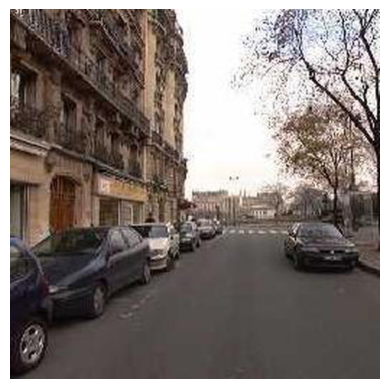

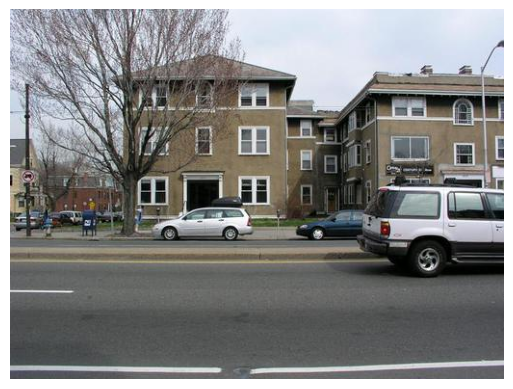

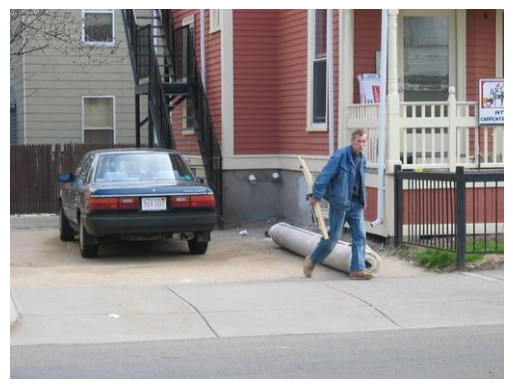

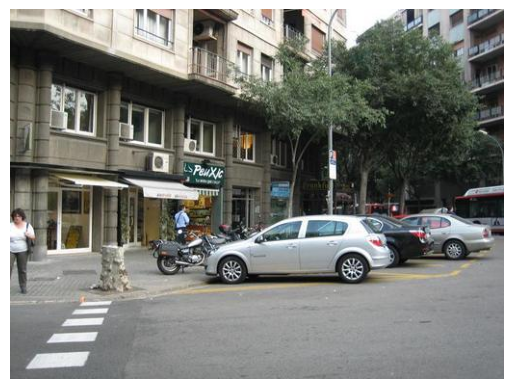

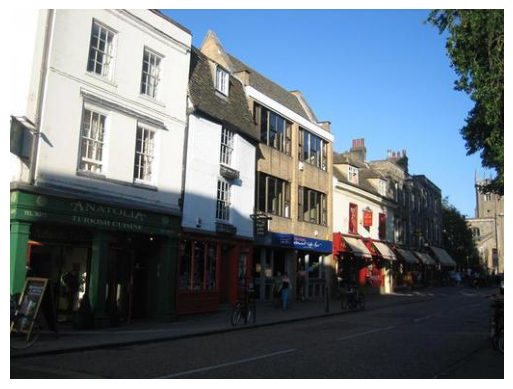

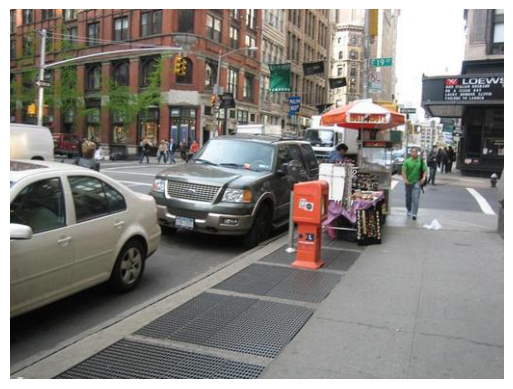

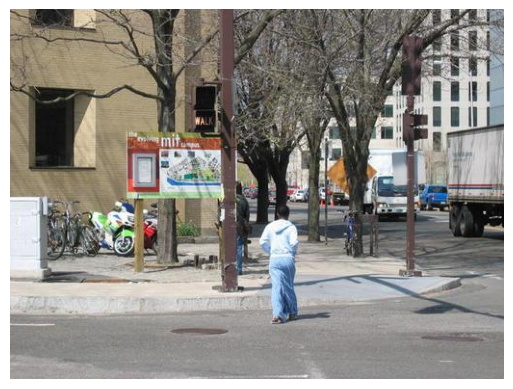

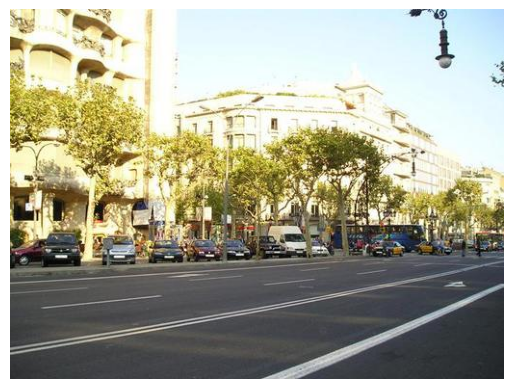

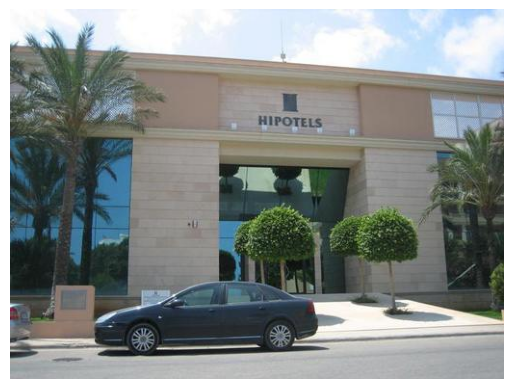

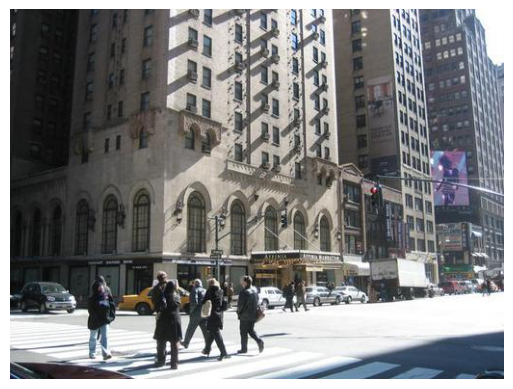

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import uuid
from PIL import Image
import os


def temp_img(index):
    image_pil = images[index]
    temp_image_path = str(uuid.uuid4())+".jpg"
    image_pil.save(temp_image_path)
    return temp_image_path

def vizualise_img(path):
    open_image = Image.open(path)
    plt.imshow(open_image)
    plt.axis('off')
    plt.show()
    os.remove(path)


for i in suitable_indexes:
    vizualise_img(temp_img(i))